<a href="https://colab.research.google.com/github/AshwathK9/Multi-Task-Learning-for-Wind-Turbine-Data-Prediction/blob/main/Copy_of_wind_projectMTLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!git --version

git version 2.34.1


In [48]:
from google.colab import auth
auth.authenticate_user()


In [49]:
!git config --global user.name "AshwathK9"
!git config --global user.email "AshwathGK96@gmail.com"


In [50]:
! git clone https://github.com/AshwathK9/Multi-Task-Learning-for-Wind-Turbine-Data-Prediction.git

fatal: destination path 'Multi-Task-Learning-for-Wind-Turbine-Data-Prediction' already exists and is not an empty directory.


In [51]:
!pwd

/content


In [52]:
!ls


Multi-Task-Learning-for-Wind-Turbine-Data-Prediction  sample_data  wind_turbine_large_data.csv


In [55]:
!mv Multi-Task-Learning-for-Wind-Turbine-Data-Prediction  sample_data

mv: cannot stat 'Multi-Task-Learning-for-Wind-Turbine-Data-Prediction': No such file or directory


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt


In [17]:
# Load Dataset
data_path = "/content/wind_turbine_large_data.csv"
data = pd.read_csv(data_path)


In [18]:
data.head()

,wind_speed,wind_direction,rpm,power_output,vibration,temperature,predicted_wind_speed,predicted_wind_direction,failure_probability,fault_type
0,11.239883,134.391354,1258.553054,4196.692462,0.853086,37.064328,9.598447,150.815872,0.531340,generator
1,23.915715,97.468082,1127.060133,19.099613,2.905775,25.913780,13.434791,279.311423,0.399720,sensor
2,19.103867,231.839836,1177.026851,1234.119346,1.457361,14.848464,6.696441,121.943864,0.953704,generator
3,16.170487,147.144302,115.443770,3704.520281,4.614407,47.476752,10.805540,202.945357,0.642110,generator
4,6.432410,9.139088,682.615597,1581.350749,2.957635,22.466829,11.799626,73.792524,0.298150,blade


In [19]:
# Preprocessing
features = ['wind_speed', 'wind_direction', 'rpm', 'power_output', 'vibration', 'temperature']
label_control = ['predicted_wind_speed', 'predicted_wind_direction']  # Real-Time Control
label_maintenance = ['failure_probability']  # Predictive Maintenance
label_fault = ['fault_type']  # Fault Detection (categorical)

X = data[features].values
y_control = data[label_control].values
y_maintenance = data[label_maintenance].values
y_fault = pd.get_dummies(data[label_fault]).values

In [20]:
# Split Data into Train and Test Sets
X_train, X_test, y_control_train, y_control_test, y_maintenance_train, y_maintenance_test, y_fault_train, y_fault_test = train_test_split(
    X, y_control, y_maintenance, y_fault, test_size=0.2, random_state=42
)


In [21]:
# Normalize Inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
# Define Multi-Task Learning Model
input_layer = Input(shape=(X_train.shape[1],))

# Shared Layers
shared = Dense(128, activation="relu")(input_layer)
shared = Dropout(0.3)(shared)
shared = Dense(64, activation="relu")(shared)

# Real-Time Control Head (Regression)
control_output = Dense(64, activation="relu")(shared)
control_output = Dense(32, activation="relu")(control_output)
control_output = Dense(2, activation="linear", name="control_output")(control_output)

# Predictive Maintenance Head (Regression)
maintenance_output = Dense(64, activation="relu")(shared)
maintenance_output = Dense(32, activation="relu")(maintenance_output)
maintenance_output = Dense(1, activation="sigmoid", name="maintenance_output")(maintenance_output)

# Fault Detection and Diagnosis Head (Classification)
fault_output = Dense(64, activation="relu")(shared)
fault_output = Dense(32, activation="relu")(fault_output)
fault_output = Dense(y_fault_train.shape[1], activation="softmax", name="fault_output")(fault_output)


In [23]:
# Combine into a Model
model = Model(inputs=input_layer, outputs=[control_output, maintenance_output, fault_output])


In [24]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        "control_output": "mse",
        "maintenance_output": "binary_crossentropy",
        "fault_output": "categorical_crossentropy"
    },
    metrics={
        "control_output": ["mse", "mae"],
        "maintenance_output": ["accuracy"],
        "fault_output": ["accuracy"]
    }
)

In [25]:
# Train the Model
model.fit(
    X_train,
    [y_control_train, y_maintenance_train, y_fault_train],
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - control_output_loss: 20290.5508 - control_output_mae: 92.6120 - control_output_mse: 20301.5859 - fault_output_accuracy: 0.3035 - fault_output_loss: 0.6890 - loss: 20302.2754 - maintenance_output_accuracy: 0.0000e+00 - maintenance_output_loss: 0.0000e+00 - val_control_output_loss: 22414.4238 - val_control_output_mae: 97.4046 - val_control_output_mse: 22214.7637 - val_fault_output_accuracy: 0.4357 - val_fault_output_loss: 0.6497 - val_loss: 22215.4160 - val_maintenance_output_accuracy: 0.0000e+00 - val_maintenance_output_loss: 0.0000e+00
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - control_output_loss: 19104.7949 - control_output_mae: 88.7781 - control_output_mse: 19116.5625 - fault_output_accuracy: 0.3349 - fault_output_loss: 0.6467 - loss: 19117.2070 - maintenance_output_accuracy: 0.0000e+00 - maintenance_output_loss: 0.0000e+00 - val_control_output_loss: 20198.5859 - val_control_output_mae: 88.9225 - val_control_output_mse: 19977.9961 -

In [26]:
# Make Predictions
test_predictions = model.predict(X_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [27]:
# Calculate Final Accuracies
# Control Task (Regression Metrics)
control_mse = mean_squared_error(y_control_test, test_predictions[0])
control_mae = mean_absolute_error(y_control_test, test_predictions[0])
print(f"Control Task - MSE: {control_mse:.2f}, MAE: {control_mae:.2f}")

# Maintenance Task (Binary Classification Accuracy)
# Convert continuous failure probability to binary labels
maintenance_preds = (test_predictions[1] > 0.5).astype(int)  # Convert probabilities to binary labels
y_maintenance_test_binary = (y_maintenance_test > 0.5).astype(int)  # Convert the ground truth to binary labels
maintenance_accuracy = accuracy_score(y_maintenance_test_binary, maintenance_preds)
print(f"Maintenance Task - Accuracy: {maintenance_accuracy:.2f}")

# Fault Detection Task (Multi-Class Classification Accuracy)
fault_preds = np.argmax(test_predictions[2], axis=1)  # Convert probabilities to class labels
fault_true = np.argmax(y_fault_test, axis=1)
fault_accuracy = accuracy_score(fault_true, fault_preds)
print(f"Fault Detection Task - Accuracy: {fault_accuracy:.2f}")

# Overall Average Accuracy (Optional)
average_accuracy = (maintenance_accuracy + fault_accuracy) / 2  # Only classification tasks averaged
print(f"Overall Average Classification Accuracy: {average_accuracy:.2f}")

Control Task - MSE: 5934.27, MAE: 49.17
Maintenance Task - Accuracy: 0.53
Fault Detection Task - Accuracy: 0.39
Overall Average Classification Accuracy: 0.46


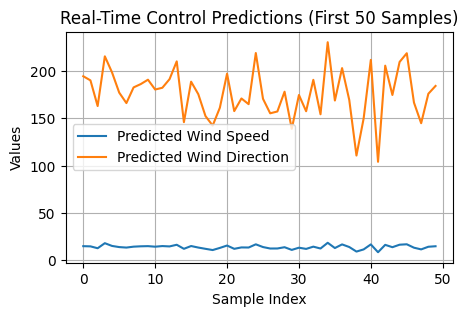

In [28]:
# Plot Graphs
# Real-Time Control Predictions (Wind Speed and Direction)
plt.figure(figsize=(5, 3))
# Assign the control output predictions to predicted_control
predicted_control = test_predictions[0]  # Assuming test_predictions[0] contains control output
plt.plot(predicted_control[:50, 0], label="Predicted Wind Speed")
plt.plot(predicted_control[:50, 1], label="Predicted Wind Direction")
plt.title("Real-Time Control Predictions (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Predictive Maintenance (Failure Probability)
plt.figure(figsize=(5, 3))
plt.plot(predicted_maintenance[:50], label="Predicted Failure Probability")
plt.title("Predictive Maintenance Predictions (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Failure Probability")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'predicted_maintenance' is not defined

<Figure size 500x300 with 0 Axes>

In [ ]:
# Fault Detection Predictions
plt.figure(figsize=(5, 3))
for class_idx in range(predicted_fault.shape[1]):
    plt.plot(predicted_fault[:50, class_idx], label=f"Fault Class {class_idx}")
plt.title("Fault Detection Predictions (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class Probabilities")
plt.legend()
plt.grid(True)
plt.show()